In [1]:
import numpy as np
import hashlib
import math
import pandas as pd 
import matplotlib.pyplot as plt
import random
import re
from nltk.tokenize import WordPunctTokenizer

from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity

import spacy

In [2]:
df = pd.read_csv('datasets/spam_cleaned.tsv', sep='\t')

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['email'] = df['email'].map(simple_tokenizer)

X_train, X_test, y_train, y_test = train_test_split(df['email'], df['label'], test_size=0.3, random_state=42)

## Q1.

The year is 1998 and your hotmail account is starting to fill up with garbage! Luckily you know some NLP and have a handy dataset to train a spam/not spam classifier with. (But beware, the dataset is very imbalanced.) To start, you'll train a baseline classifier using features from TFIDF.


### Q1.a)

Don't forget your computer is also from 1998 and your computing power is pretty bad, so we'll have to limit this classifier to only using 50 features.
Implement a function that returns the fitted vectorizer, and precision and recall, respectively, on the spam class from a K Nearest Neighbors classifier using default TFIDF features (except max_features=50).

In [3]:
def get_precision_recall_of_spam_tfidf(X_train, y_train, X_test, y_test):
    '''Returns a fitted TfidfVectorizer and the test precision and recall on the 'spam' class
       from a KNeighborsClassifier trained on the inputted train data
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer with max_features == 50, fitted to X_train
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the vectorized training data
        recall (float): The recall score of the spam class on the test data from a
                        KNeighborsClassifier fitted to the vectorized training data
    '''
    
    # YOUR CODE HERE
    vectorizer = TfidfVectorizer(max_features=50)
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_vec,y_train)
    
    y_pred = clf.predict(X_test_vec)
    
    precision = precision_score(y_test,y_pred,pos_label='spam')
    recall = recall_score(y_test,y_pred,pos_label='spam')
    
    return vectorizer, precision, recall

In [4]:
vectorizer, precision, recall = get_precision_recall_of_spam_tfidf(X_train, y_train, X_test, y_test)

assert math.isclose(precision, 0.8395061728395061)
assert math.isclose(recall, 0.6210045662100456)

### Q1.b)

Let's see what we can do to get both precision and recall up. We don't want to be bombarded with spam but we also don't want to miss too many real emails.

First, look at the selected features of the fitted tfidf vectorizer, sorted by their inverse document frequency (in descending order). 

In [5]:
def get_ngrams_sorted_by_idf(fitted_vectorizer):
    '''Returns the features of a fitted TfidfVectorizer ordered by their idf score
    
    Parameters:
        fitted_vectorizer (TfidfVectorizer): A fitted TfidfVectorizer
    
    Returns:
        ngrams_sorted (list): The features of fitted_vectorizer sorted in ascending order
                              by their idf score
    '''
    df = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
    ngrams_sorted = df.sort_values(by=['idf_weights'],ascending=False)['idf_weights'].index.tolist()
    
    return ngrams_sorted

In [6]:
assert(hashlib.sha256(get_ngrams_sorted_by_idf(vectorizer)[5].encode()).hexdigest() == "5ef5ef0364b6939c4ca61f34b393f7b368d1be8619647aaf83d5b395919ab629")
assert(hashlib.sha256(get_ngrams_sorted_by_idf(vectorizer)[48].encode()).hexdigest() == "bb0347a468d97e98a9c00e37cebec1ab930f6f1221cae0f1fbb92b07e1900ba2")

In [7]:
# show most specifc 30 features of the 50 selected features
get_ngrams_sorted_by_idf(vectorizer)[:30]

['then',
 'out',
 'free',
 'know',
 'll',
 'all',
 'gt',
 'lt',
 'go',
 'from',
 'when',
 'ok',
 'how',
 'what',
 'up',
 'this',
 'ur',
 'no',
 'if',
 'with',
 'do',
 'be',
 'we',
 'will',
 'just',
 'get',
 'at',
 'or',
 'can',
 'not']

### Q1.c)

Let's also check the number of features:

In [8]:
def get_number_of_features(fitted_vectorizer):
    '''Returns the number of features of a fitted TfidfVectorizer
    
    Parameters:
        fitted_vectorizer (TfidfVectorizer): A fitted TfidfVectorizer
    
    Returns:
        vocab_size (int): The number of features of fitted_vectorizer 
    '''
    vocab_size = len(vectorizer.get_feature_names())
    return vocab_size

In [9]:
num_features = get_number_of_features(vectorizer)

assert num_features == 50

### Q1.d)

Hmm, looks like we might need to do some feature selection!

To try something simple, reimplement the KNN function from 1a, but avoiding English stopwords.

In [10]:
def get_precision_recall_of_spam_tfidf_no_stopwords(X_train, y_train, X_test, y_test):
    '''Returns a fitted TfidfVectorizer with English stopwords removed and the test precision
       and recall on the 'spam' class from a KNeighborsClassifier trained on the inputted train data
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer with max_features=50 and stopwords='english',
                                      fitted to X_train
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the vectorized training data
        recall (float): The recall score of the spam class on the test data from a
                        KNeighborsClassifier fitted to the vectorized training data
    '''
    # YOUR CODE HERE
    vectorizer = TfidfVectorizer(max_features=50,stop_words='english')
    vectorizer.fit(X_train)
    X_train_vec = vectorizer.transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_vec,y_train)
    
    y_pred = clf.predict(X_test_vec)
    
    precision = precision_score(y_test,y_pred,pos_label='spam')
    recall = recall_score(y_test,y_pred,pos_label='spam')
    
    return vectorizer, precision, recall

In [11]:
vectorizer_stopwords, precision_stopwords, recall_stopwords = \
                    get_precision_recall_of_spam_tfidf_no_stopwords(X_train, y_train, X_test, y_test)

assert math.isclose(precision_stopwords, 0.8636363636363636)
assert math.isclose(recall_stopwords, 0.6073059360730594)

## Q2.

Not bad, not great, after some simple feature selection we have better precision but slightly worse recall. Still you are confident you can push it a bit further.

Repeat Q1, but this time, in addition to stopwords, use the chi-squared method to get the relevant 50 features, and output the fitted vectorizer, fitted SelectKBest, precision, and recall:

In [12]:
def get_precision_recall_of_spam_chi_squared(X_train, y_train, X_test, y_test):
    '''Returns a fitted TfidfVectorizer, a fitted SelectKBest and the test precision and recall on
       the 'spam' class from a KNeighborsClassifier trained on the inputted train data
    
    Parameters:
        X_train (Series): Text data for training
        y_train (Series): Labels corresponding to X_train
        X_test (Series): Text data for testing
        y_test (Series): Labels corresponding to X_test

    Returns:
        vectorizer (TfidfVectorizer): TfidfVectorizer with  stopwords='english', fitted to X_train
        ch2 (SelectKBest): SelectKBest with score function chi2 and k=50, fitted to vectorized X_train
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the feature-selected training data
        recall (float): The recall score of the spam class on the test data from a KNeighborsClassifier
                        fitted to the feature-selected training data
    '''
    vectorizer_ch2 = TfidfVectorizer(stop_words='english')
    
    vectorizer_ch2.fit(X_train)
    X_train_vec = vectorizer_ch2.transform(X_train)
    X_test_vec = vectorizer_ch2.transform(X_test)
    
    
#     chi_values, p_values = chi2(X_train_vec, y_train)
    ch2_train = SelectKBest(chi2, k=50)
    
    ch2 = ch2_train.fit(X_train_vec, y_train)
    
#     feature_names = vectorizer_ch2.get_feature_names()
#     most_important_features = [feature_names[i] for i in ch2.get_support(indices=True)]
    
    X_train_chi = ch2_train.transform(X_train_vec)
    X_test_chi = ch2_train.transform(X_test_vec)
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_chi,y_train)
    
    y_pred = clf.predict(X_test_chi)
    
    precision_ch2 = precision_score(y_test,y_pred,pos_label='spam')
    recall_ch2 = recall_score(y_test,y_pred,pos_label='spam')
    
    return vectorizer_ch2, ch2, precision_ch2, recall_ch2

In [13]:
vectorizer_ch2, ch2, precision_ch2, recall_ch2 = \
                    get_precision_recall_of_spam_chi_squared(X_train, y_train, X_test, y_test)

assert math.isclose(precision_ch2, 0.9101123595505618)
assert math.isclose(recall_ch2, 0.7397260273972602)

In [14]:
# Again, we'll check the most important features
most_important_features = [vectorizer_ch2.get_feature_names()[i] for i in ch2.get_support(indices=True)]
print(most_important_features)

['000', '100', '1000', '10p', '150p', '150ppm', '16', '18', '50', '500', '5000', 'apply', 'award', 'awarded', 'camera', 'cash', 'claim', 'collection', 'com', 'contact', 'cs', 'draw', 'entry', 'free', 'guaranteed', 'landline', 'latest', 'line', 'mobile', 'national', 'nokia', 'po', 'prize', 'rate', 'receive', 'reply', 'ringtone', 'service', 'stop', 'text', 'tone', 'tones', 'txt', 'uk', 'urgent', 'video', 'weekly', 'win', 'won', 'www']


## Q3.

Chi-squared feature selection helped get both metrics up a little! 

You now feel confident enough to verify if these features are in fact meaningful for classifying your data, so you decide to plot them.

In [15]:
sub_punct = lambda s: re.sub(r'\s+\W*[a-z]?\W*\s+', ' ', s)

In [16]:
for feature in most_important_features:
    print('Documents that contains the word(s) "%s"' % feature)
    print('----')
    docs = X_train.apply(sub_punct).str.lower().str.contains(feature)
    print(str(y_train[docs].value_counts()) + '\n\n')

Documents that contains the word(s) "000"
----
spam    115
ham       3
Name: label, dtype: int64


Documents that contains the word(s) "100"
----
spam    71
ham      2
Name: label, dtype: int64


Documents that contains the word(s) "1000"
----
spam    35
ham      1
Name: label, dtype: int64


Documents that contains the word(s) "10p"
----
spam    23
Name: label, dtype: int64


Documents that contains the word(s) "150p"
----
spam    102
Name: label, dtype: int64


Documents that contains the word(s) "150ppm"
----
spam    35
Name: label, dtype: int64


Documents that contains the word(s) "16"
----
spam    66
ham      2
Name: label, dtype: int64


Documents that contains the word(s) "18"
----
spam    91
ham      1
Name: label, dtype: int64


Documents that contains the word(s) "50"
----
spam    255
ham       4
Name: label, dtype: int64


Documents that contains the word(s) "500"
----
spam    65
Name: label, dtype: int64


Documents that contains the word(s) "5000"
----
spam    31
Name: la

## Q4.

You now want dimensionality reduction techniques like SVD and PCA. 

In [17]:
# set a seed for random
seed = 1234

### Q4.a)

Transform the training data with tfidf avoiding stopwords, and calculate the total variance 

In [18]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)
# The total variance was calculated only on the X_train after the transformation of the vectorizer
total_variance = np.var((X_train_vec).toarray(),axis=0).sum()

In [19]:
assert math.isclose(total_variance, 0.9897797614643888)

### Q4.b)

Write a function that fits sklearn's TruncatedSVD with 50 components to the tfidf data, trains a KNN classifier, and outputs the total explained variance, precision, and recall

In [20]:
def get_precision_recall_of_svd(X_train_vec, y_train, X_test_vec, y_test):
    '''Returns the total explained variance of SVD fitted to the Tfidf-vectorized input data,
       and the test precision and recall on the 'spam' class from a KNeighborsClassifier
       trained on the dimensionality-reduced train data
    
    Parameters:
        X_train_vec (Series): Text data for training vectorized by Tfidf
        y_train (Series): Labels corresponding to X_train_vec
        X_test_vec (Series): Text data for testing vectorized by Tfidf
        y_test (Series): Labels corresponding to X_test_vec

    Returns:
        explained variance (float): The total explained variance of a fitted TruncatedSVD
                                    with n_components=50 and random_state=seed
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the SVD'd training data
        recall (float): The recall score of the spam class on the test data from a
                        KNeighborsClassifier fitted to the SVD'd training data
    '''
    # YOUR CODE HERE
    svd = TruncatedSVD(n_components=50,random_state=seed)
    svd.fit(X_train_vec)
    
    X_train_trunc = svd.transform(X_train_vec)
    X_test_trunc = svd.transform(X_test_vec)
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_trunc,y_train)
    
    y_pred = clf.predict(X_test_trunc)
    
    explained_variance = np.var(X_train_trunc,axis=0).sum()
    
    precision = precision_score(y_test,y_pred,pos_label='spam')
    recall = recall_score(y_test,y_pred,pos_label='spam')    
    
    return explained_variance, precision, recall

In [21]:
var, precision_svd, recall_svd = \
                    get_precision_recall_of_svd(X_train_vec, y_train, X_test_vec, y_test)

assert math.isclose(var, 0.16416346460759212)
assert math.isclose(precision_svd, 0.9109947643979057)
assert math.isclose(recall_svd, 0.7945205479452054)

## Q5

SVD got us a few points higher in recall than chi-squared, nice! Remember now some of the pros and cons of SVD and other dimensionality reduction techniques. While SVD performed better, likely because in theory it can capture information from more than 50 ngrams (whereas in chi-squared the number of features was in a direct correspondence with the number of ngrams), with SVD we lose interpretability and can't examine the most important features!

Now let's try PCA.

Write a function that fits sklearn's PCA with 50 components to the tfidf data from Q4, trains a KNN classifier, and outputs the total explained variance, precision, and recall.

In [22]:
def get_precision_recall_of_pca(X_train_vec, y_train, X_test_vec, y_test):
    '''Returns the total explained variance of PCA fitted to the Tfidf-vectorized input data,
       and the test precision and recall on the 'spam' class from a KNeighborsClassifier
       trained on the dimensionality-reduced train data
    
    Parameters:
        X_train_vec (Series): Text data for training vectorized by Tfidf
        y_train (Series): Labels corresponding to X_train_vec
        X_test_vec (Series): Text data for testing vectorized by Tfidf
        y_test (Series): Labels corresponding to X_test_vec

    Returns:
        explained variance (float): The total explained variance of a fitted PCA
                                    with n_components=50 and random_state=seed
        precision (float): The precision score of the spam class on the test data from a
                           KNeighborsClassifier fitted to the PCA'd training data
        recall (float): The recall score of the spam class on the test data from a
                        KNeighborsClassifier fitted to the PCA'd training data
    '''
    dense_X_train = X_train_vec.toarray()
    dense_X_test = X_test_vec.toarray()
    
    pca = PCA(n_components=50,random_state=seed)
    pca.fit(dense_X_train)
    
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca = pca.transform(dense_X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(X_train_pca,y_train)
    
    y_pred = clf.predict(X_test_pca)
    
#     explained_variance = 1.0*np.var(X_train_pca,axis=0).sum()
    
    explained_variance = pca.explained_variance_.sum()
    
    precision = precision_score(y_test,y_pred,pos_label='spam')
    recall = recall_score(y_test,y_pred,pos_label='spam')
    
    return explained_variance, precision, recall

In [23]:
var_pca, precision_pca, recall_pca = \
                    get_precision_recall_of_pca(X_train_vec, y_train, X_test_vec, y_test)

assert math.isclose(var_pca, 0.1658261296302505)
assert math.isclose(precision_pca, 0.9067357512953368)
assert math.isclose(recall_pca, 0.7990867579908676)

## Q6.

Now we'll change gears a bit and look into word vectors. In Learning Notebook 3 we told you that word vectors can be visualized after being projected into 2D space, and we showed you this diagram:

<img src="./media/word-vectors-projection.png" width="600">

Now we'll try to combine what you've learned about word embeddings and PCA to make our own visualization!

In [24]:
# load word embeddings

nlp = spacy.load('en_core_web_md')

### Q6.a)

First, to get comfortable with spacy, get the vector for the word "tree" and return the sum of its elements

In [25]:
sum_tree = nlp('tree').vector.sum()

In [26]:
assert math.isclose(sum_tree, 2.3972085, abs_tol=0.00001)

### Q6.b) 

Next, write a function that does a fit_transform of sklearn's PCA to a given set of word vectors, using the correct number of components. The function should return the reduced dimension word vectors.

In [27]:
def reduce_word_vecs(vectors):
    '''Returns PCA-reduced word vectors of the input vectors
    
    Parameters:
        vectors (np.array): Word vectors to be reduced

    Returns:
        reduced_vecs (np.array): Word vectors reduced to the number of dimensions
                                 suitable for plotting with random_state=seed
    '''
    # YOUR CODE HERE
    # The vectors that are introduced are supposed to be reduced using PCA
    pca = PCA(n_components=2,random_state=seed)
    pca.fit(vectors)
    
    reduced_vecs = pca.transform(vectors)
    
    return reduced_vecs

In [28]:
test_vectors = np.array([[0.1, 0.2, 0.3, 0.4], [0.3, 0.5, 0.1, 0.7], [0.8, 0.6, 0.2, 0.4]])
reduced_vecs = reduce_word_vecs(test_vectors)

assert reduced_vecs.shape == (3,2)
assert math.isclose(reduced_vecs[1][1], 0.24736592153367926)
assert math.isclose(reduced_vecs[2][0], 0.43388622222454437)

Now, we'll create an array of ~100,000 of spacy's word vectors and use your PCA function to reduce them. If you're curious about using the full amount of word vectors, just remove the `if` statement in the below function, but beware it will use a lot of memory!

We'll also set a list of words that we'll plot later and force our set of vectors to include these.

In [29]:
words_to_plot = ['banana', 'pineapple', 'mango', 'red', 'blue', 'yellow', 'woman', 'man', 'child', 'playing',
                 'reading', 'studying', 'nintendo', 'sony', 'xbox', 'sad', 'angry', 'bored']

In [30]:
# Caution: if you run this cell more than once, you may get different words than the ones
# expected for the rest of the exercises. If that happens, restart the kernel and try again

random.seed(123)

full_vocab_vecs = []
vocab_strings = []
for tok in list(nlp.vocab.strings):
    if tok in words_to_plot or random.random() < 0.07:
        full_vocab_vecs.append(nlp.vocab.get_vector(tok))
        vocab_strings.append(tok)

vocab_array = np.array(full_vocab_vecs)

In [31]:
print('Word vectors shape pre-PCA: {}'.format(vocab_array.shape))

full_vocab_reduced = reduce_word_vecs(vocab_array)

print('Word vectors shape after PCA: {}'.format(full_vocab_reduced.shape))

Word vectors shape pre-PCA: (103201, 300)
Word vectors shape after PCA: (103201, 2)


In [32]:
assert math.isclose(full_vocab_reduced[100][0], -3.0945618, abs_tol=0.00001)
assert math.isclose(full_vocab_reduced[9999][0], -0.94902855, abs_tol=0.00001)

### Q6.c)

Time to plot! For this, we'll limit the visualized words to a small subset.

In [33]:
coords = []
for word in words_to_plot:
    idx = vocab_strings.index(word)
    coords.append(full_vocab_reduced[idx])

coords_array = np.array(coords)

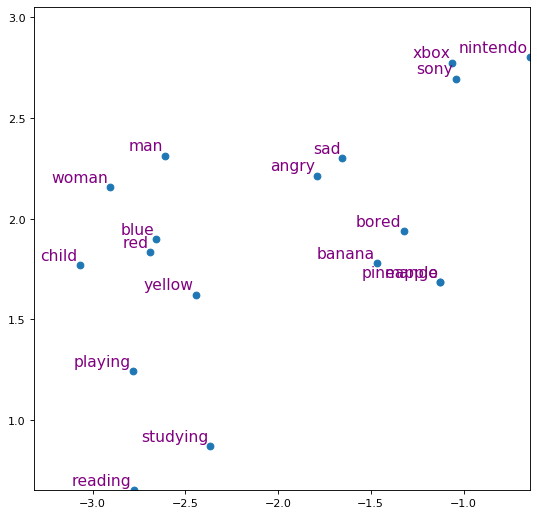

In [34]:
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

plt.xlim(min([x for x in coords_array[:,0]])-.25, max([x for x in coords_array[:,0]]))
plt.ylim(min([y for y in coords_array[:,1]]), max([y for y in coords_array[:,1]])+0.25)
plt.scatter(coords_array[:,0], coords_array[:,1])

for item, x, y in zip(words_to_plot, coords_array[:,0], coords_array[:,1]):
    plt.annotate(item, xy=(x, y), xytext=(-2, 2), textcoords='offset points', 
                 ha='right', va='bottom', color='purple', fontsize=14 )
plt.show()

The PCA seems to have worked! In the diagram we can see similar types of words closer together. But of course, take these visualizations with a grain of salt because it is practically impossible to preserve all distances in a high dimensional space in just 2 dimensions.

### Q6.d) 

As a final exercise, we'll look at some word similarities.

Write a function that returns the next closest word in terms of cosine similarity to a given word. If there are multiple words with the same highest similarity, return all of them.

Hint: you can use the already-imported `cosine_similarity` function from sklearn to compute cosine similarity.

In [35]:
def closest_word(input_word, words_in_vocab, word_vectors):
    '''Returns a list of the closest word or words to the input word, based on cosine similarities
       of the word vectors given
    
    Parameters:
        input_word (string): Search for the closest words to this word
        words_in_vocab (list): Vocabulary associated with the vectors in word_vectors
        word_vectors (np.array): Word vectors associated with the strings in words_in_vocab

    Returns:
        closest_words_list (list): List of strings containing the closest word or words to
                                   input_word, based on cosine similarities of the word_vectors
    '''
    # YOUR CODE HERE    
    input_new = vocab_strings.index(input_word)
    word_coords = full_vocab_reduced[input_new].reshape(1,2)
    
    temp_vectors = word_vectors
    temp_words = words_in_vocab 
    
    temp_word_to_remove = temp_words.index(input_word)
    
    temp_vectors = np.delete(temp_vectors,temp_word_to_remove).T
    temp_words = temp_words.pop(temp_word_to_remove)

#     print(words_to_plot)
    
    closest_word = cosine_similarity(word_coords,temp_vectors)[0]
    closest_word_max = closest_word.max()
    
    temp_dictionary = dict(zip(temp_words, closest_word))
    closest_words_list = [n for n,d in temp_dictionary.items() if d == closest_word_max]
    
    return closest_words_list

In [36]:
closest_word('nintendo', words_to_plot, coords_array)

ValueError: Expected 2D array, got 1D array instead:
array=[-1.4654475   1.7810751  -1.1244025   1.6835366  -1.1244025   1.6835366
 -2.6883478   1.8329829  -2.655622    1.8988637  -2.4444401   1.6237214
  2.155753   -2.6095169   2.3120847  -3.068657    1.769805   -2.7816186
  1.2444582  -2.7777147   0.653446   -2.3644063   0.8710694  -0.64414203
  2.798904   -1.0430362   2.6942818  -1.0606452   2.7730954  -1.6530125
  2.2990823  -1.790398    2.2130394  -1.3233541   1.9380981 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
words_to_plot

In [ ]:
input_new = vocab_strings.index('banana')
word_coords = full_vocab_reduced[input_new].reshape(1,2)
word_coords

In [ ]:
input_new = vocab_strings.index('nintendo')
word_coords = full_vocab_reduced[input_new].reshape(1,2)
word_coords

In [ ]:
words_to_plot

In [ ]:
assert(hashlib.sha256(closest_word('nintendo', words_to_plot, coords_array)[0].encode()).hexdigest() == "f711da60664c04c146d7a47b722c38a8d0bf46c3f52c2084c5c8d1cb78138e73")
assert(hashlib.sha256(closest_word('playing', words_to_plot, coords_array)[0].encode()).hexdigest() == "435c149cbc6a5e5cc373cd33347d4c336a22160e06b7df61092b66e56f4d55ec")
assert(hashlib.sha256(closest_word('pineapple', words_to_plot, coords_array)[0].encode()).hexdigest() == "6815f3c300383519de8e437497e2c3e97852fe8d717a5419d5aafb00cb43c494")